In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.integrate as sci
import time 
import threading
import sys
import multiprocessing as multiproc

# the function library
from projectlib import *

## Parameters

In [7]:
class Data:
    def __init__(self, dimension, name, commuters_day, N):
        "Dimension gives the dimension of the system, i.e. number of cells"
        # ------- TO DO ---------
        # Depending on the system this has to be adjusted
        self.dimension = dimension
        
        "Alpha describes the rate of infection"
        self.alpha = 0.4 # Dimensions day^(-1)

        "Beta describes the recovery rate"
        self.beta = 1/14 # Dimensions day^(-1)

        "p is the probability to die from the disease"
        self.p = 2.64e-2
        
        """
        Commuters is an array describing the commuters from and to the different cells. 
        The structure is: The entries in column i are how many commute from i to the cell of the row.
                          Thus, the entries of the row i describe how many commute from different cells to cell i.
        """

        self.commuters = np.array([np.ones(self.dimension) for i in range(self.dimension)])
        "load the txt with given name"
        file = np.loadtxt(name, delimiter="\t")
        "fill commuters with the entries from the file. Note the break statement so it doesn't go to far"
        i = 0
        for row in file:
            if i >= self.dimension:
                break
            self.commuters[i] = np.asarray(row[0:self.dimension])
            i += 1
        
        "Part of day that commuters are in other cells. This is the same value for all cells"
        self.commuters_day = commuters_day

        "Array of population in every cell"
        # ------- TO DO ---------
        # figure out how to best do this
        self.N = N

        
        
    def commutersFrom(self, cfrom):
        """Function to extract the commuters from a cell

        Args:
            cfrom (integer): the cell 

         Returns:
            array: array containing commuters from cfrom
        """
        # ------- TO DO ---------
        # optimize the algorithm
        "Sorting out the necessary entries into array a."
        a = np.zeros(self.dimension)
        for i in range(self.dimension):
            a[i] = self.commuters[i][cfrom]
            
        return a 
    
    def commutersTo(self, cto):
        """Function to return an array with number of commuters coming to cto from other cells.

        Args:
            cto (integer): the cell to which the commuters travel

        Returns:
            array: array containing the commuters to cto.
        """
        return self.commuters[cto][:]
       
        
        

## Functions

In [8]:


def function_of_system(timestep, functions,  data, methode, t0):
    """Function to calculate the time derivatives of the dynamic SIRD modell with commuters. This function uses multiple approachs for different variant of the system based on prior assumptions. 

        Args:
            functions (array): array with the functions that define the system of equations. Structure [S_1, ... , S_n, I_1, .... , I_n, R_1, ... , R_n, D_1, ... , D_n]
            timestep (float): time of timestep. t=1 is 1 day
            data (class): the class with the relevant data
            methode (string): dictates what methode is to be used. The choices are "constant", "heaviside"
            t0 (array): array with len = 3 filled with times at which the heaviside functions in the "heaviside" methode switch. 
                Note: all values of t0 have to be between 0 and 1.

        Returns:
            array: array containing the derivatives of functions at time t.
    """
    # array with infected
    Infected = functions[data.dimension:2*data.dimension]

    # making array with the effective infected Ieff and the effective population Neff
    Ieff = np.array([effective_infected(data.commutersTo, data.commutersFrom, data.N, i, Infected, data.dimension) for i in range(data.dimension)])

    Neff = np.array([effective_population(data.commutersFrom, data.N, i) for i in range(data.dimension)])

    # initializing the return array with the time derivatives of functions
    dfuncdt = np.ones(data.dimension*4)

    "~~~~~~~~~~~~~~~~~ See the PDF / LaTeX for further explanation of the equations ~~~~~~~~~~~~~~~~~~~~~~~~"

    # ------------------------------------
    # -      Constant Coefficients       -
    # ------------------------------------

    tt = 0.6

    if methode == "constant":
            
        # the for loop to fill dfuncdt

        for i in range(data.dimension):
            # see LaTeX for equations
            # dS/dt
            dfuncdt[i] =  - data.alpha*tt * functions[i] * functions[i + data.dimension] - (1 - tt) * data.alpha * (Neff[i] * functions[i] * Ieff[i] / data.N[i] + functions[i] / data.N[i] * np.sum(data.commutersFrom(i) * Ieff))

            # dI/dt \propto -dSdt
            dfuncdt[i + data.dimension] = - dfuncdt[i] - data.beta * functions[i + data.dimension]

            # dR/dt
            dfuncdt[i + 2 * data.dimension] = (1 - data.p) * data.beta * functions[i + data.dimension]

            # dD/dt
            dfuncdt[i + 3 * data.dimension] = data.p * data.beta * functions[i + data.dimension]


    # ------------------------------------
    # -      Heaviside Coefficients      -
    # ------------------------------------


    elif methode == "heaviside":


        # the for loop to fill dfuncdt
        for i in range(data.dimension):
            # see LaTeX for equations
            # dS/dt
            dfuncdt[i] = - data.alpha * (periodic_heaviside(timestep, t0[0]) + periodic_heaviside(timestep, t0[2]) - 1) * functions[i] * functions[i + data.dimension] - (periodic_heaviside(timestep, t0[1]) - periodic_heaviside(timestep, t0[2])) * data.alpha * (Neff[i] * functions[i] * Ieff[i] / data.N[i] + functions[i] / data.N[i] * np.sum(data.commutersFrom(i) * Ieff))

            # dI/dt \propto -dSdt
            dfuncdt[i + data.dimension] = - dfuncdt[i] - data.beta * functions[i + data.dimension]

            # dR/dt
            dfuncdt[i + 2 * data.dimension] = (1 - data.p) * data.beta * functions[i + data.dimension]

            # dD/dt
            dfuncdt[i + 3 * data.dimension] = data.p * data.beta * functions[i + data.dimension]

    
    
    
    
    
    
    
    # returning the derivatives at time t
    return dfuncdt



# Function for using scipy.integrate.odeint, as the arguments are switched
def system_function(functions, timestep, data, methode, t0):
    return function_of_system(timestep, functions, data, methode, t0)




## Comparing $\alpha$'s

## Testruns
This section is purely for testing new implementations in the code

constant took: 0.05504965782165527 heaviside took: 0.7550780773162842


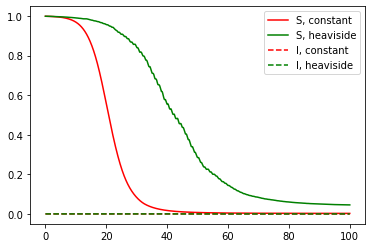

(10000,)
[0.999      0.999      0.999      ... 0.04649132 0.04649075 0.04649055]
[0.999      0.99899601 0.998992   ... 0.00385455 0.00385449 0.00385442]


In [9]:
"""
This is a testrun to see whether or not the functions work as intended. The values have no meaning and are created at random, or rather random to a certain degree as there still are some requirements to the parameters. The testrun also consists of comparing the times that the methodes use
"""




# defining a class, setting initial conditions, defining time and creating the distribution of commuters days
testdata = Data(12, "Pendler.txt", 0.2, np.array([1e6, 2e6, 3e6, 4e6, 1e6, 1e6, 1e6, 1e6, 1e6, 1e6, 1e6, 1e6]))



initial_conditions = [0.999, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.001, 0, 0, 0, 0, 0.001, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
t = np.linspace(0, 100, 10000)
tzero = np.array([0, 0.4, 0.8])

# timing constant methode
t10 = time.time()
sol = sci.solve_ivp(fun=function_of_system, t_span=(0, 100), y0=initial_conditions, method="RK45", args=(testdata, "constant", tzero), t_eval=t)

t11 = time.time()

# timing heaviside methode

t20 = time.time()
sol1 = sci.solve_ivp(fun=function_of_system, t_span=(0, 100), y0=initial_conditions, method="RK45", args=(testdata, "heaviside", tzero), t_eval=t)
t21 = time.time()

print("constant took:", t11-t10, "heaviside took:",  t21-t20)

plt.plot(t, sol.y[0], "r", label="S, constant")
plt.plot(t, sol1.y[0], "g", label="S, heaviside")
plt.plot(t, sol.y[7], "--r", label="I, constant")
plt.plot(t, sol1.y[7], "--g", label="I, heaviside")
plt.legend()
plt.show()




print(np.shape(sol.t))


print(sol1.y[0])

y1 = sci.odeint(func=system_function, y0=initial_conditions, t=t, args=(testdata, "constant", tzero))

print(y1[:, 0])



## Plotting





In [10]:
from multiprocessing.dummy import Pool as ThreadPool 


def plotting(index):
    fig = plt.figure(figsize=(8, 6))
    plt.plot(t, sol.y[index], label="S in cell %g" % (index + 1))
    plt.plot(t, sol.y[7 + index], label="I in cell %g" % (index + 1))
    plt.legend(loc="best")
    plt.title("Compartments in cell %g" % (index + 1))
    plt.xlabel("t [days]")
    plt.ylabel("Size of Compartment")
    plt.grid()
    plt.savefig("Media/Plots/plot_%g.pdf" % index, dpi=200)
    plt.close(fig)


t0 = time.time()
for i in range(7):
    plotting(i)
t1 = time.time()



print("for loop", t1-t0)





t3 = time.time()
arg = [(i,) for i in range(7)]

print(tuple(arg))




pool = ThreadPool(1)
pool.starmap(plotting, arg) 
pool.close() 
pool.join()

t4 = time.time()
print("multiprocessing", t4- t3)

"""
#if __name__ == "__main__":  
args = [(0,), (1,), (2,), (3,)]
proclist = []
p = multiproc.Process(target=plotting, args=(1,))
p.start()
p.join()
p.close()
"""

"""
    for a in args:
        p = multiproc.Process(target=plotting, args=a)
        p.start()
        proclist.append(p)    
    
    for p in proclist:
        p.join()
"""

for loop 0.7568001747131348
((0,), (1,), (2,), (3,), (4,), (5,), (6,))
multiprocessing 0.702587366104126


'\n    for a in args:\n        p = multiproc.Process(target=plotting, args=a)\n        p.start()\n        proclist.append(p)    \n    \n    for p in proclist:\n        p.join()\n'

In [11]:


def write(i, x):
    print(i, "---", x)


a = [1, 2, 3]
b = [4, 5, 6] 




In [12]:
a = initial_compartment_distribution(12, "2020/07/24")
initCond = np.zeros(12*4)

for i in range(12):
    initCond[i] = a[i][0]
    initCond[i + 12] = a[i][1]
    initCond[i + 24] = a[i][2]
    initCond[i + 36] = a[i][3]
    
N = region_setup(12)[0]


tzero = np.array([0, 0.4, 0.8])


simulation001 = Data(12, "Pendler.txt", 0.6, import_rki_data(N, 7)[2])

t = np.linspace(0, 100, 10000)

sol1 = sci.solve_ivp(fun=function_of_system, t_span=(0, 100), y0=initCond, method="RK45", args=(simulation001, "heaviside", tzero), t_eval=t)
sol = sci.solve_ivp(fun=function_of_system, t_span=(0, 100), y0=initCond, method="RK45", args=(simulation001, "constant", tzero), t_eval=t, dense_output=True)



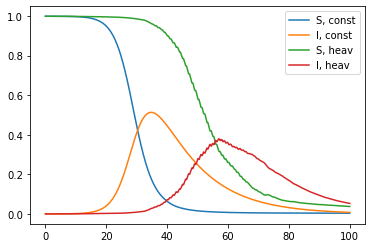

In [13]:

plt.plot(sol.t, sol.y[0], label="S, const")
plt.plot(sol.t, sol.y[12], label="I, const")
plt.plot(sol1.t, sol1.y[0], label="S, heav")
plt.plot(sol1.t, sol1.y[12], label="I, heav")
plt.legend()
plt.show()

In [6]:
print(np.shape(sol.t))

(10000,)
